In [1]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import numpy as np
import json


In [2]:
class BigQuery():
    def __init__(self):
        self.credentials =json.load(open("credentials.json"))
        self.client = bigquery.Client(
            credentials=service_account.Credentials.from_service_account_info(self.credentials))

    def query(self, project, chave_nota = None):

        if project == "Intelipost":
            query = f"""
                    SELECT 
                   uf, transportadora, data_criacao, data_despacho,previsao_entrega_cliente,data_entrega,
                   previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,
                   chave_da_nota,quantidade_de_ocorrencias
                    FROM `caffeine-web-server.Intelipost.pedido_entrega`
                    WHERE data_criacao > "2023-06-01"AND 
                    canal_de_vendas = "Ecommerce" AND
                    data_entrega IS NOT NULL AND
                    data_despacho IS NOT NULL
                    """
        elif project == 'ecommerce':
            query = f"""
                    WITH chaves AS(
                    SELECT numero_pedido_cliente, chave_acesso_NFe
                    FROM `caffeine-web-server.Omie_Caffeine_ES.Pedidos` 
                    WHERE chave_acesso_NFe IN {chave_nota}
                    )

                    SELECT chaves.chave_acesso_NFe, DATE(LEFT(shopify.criado_em,10)) as criado_shopify, 
                    FROM `caffeine-web-server.Shopify_BR.Pedidos` as shopify
                    INNER JOIN chaves ON shopify.id_pedido = chaves.numero_pedido_cliente
                    WHERE shopify.status_financeiro = "paid"
                    """

        result = self.bq_result(query)
        return result

    def bq_result(self, query_text):

        query_job = self.client.query(query_text)
        results = query_job.result()
        dataframe = pd.DataFrame([dict(row) for row in results])
        return dataframe
    


In [3]:
def get_date_order(chaves_de_nota):
    df_notas = pd.DataFrame()
    
    chunk_size = 15000
    num_chunks = len(chaves_de_nota) // chunk_size + (len(chaves_de_nota) % chunk_size > 0)

    # Loop to divide the tuple into chunks
    for i in range(num_chunks):
        start_index = i * chunk_size
        end_index = (i + 1) * chunk_size
        current_chunk = chaves_de_nota[start_index:end_index]

        df_temp = BigQuery().query("ecommerce",current_chunk)
        df_notas = pd.concat([df_temp,df_notas], axis=0, ignore_index = True)
    return df_notas


In [4]:
intelipost_data = BigQuery().query("Intelipost")

In [6]:
intelipost_data.head()

,uf,transportadora,data_criacao,data_despacho,previsao_entrega_cliente,data_entrega,previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias
0,AP,Loggi,2023-09-26 11:56:40.905000+00:00,2023-09-26 17:48:27+00:00,2023-10-15 23:58:59+00:00,2023-10-13 13:15:59+00:00,2023-10-13 23:59:59+00:00,Entregue,12.0,Capital,32230927403527000385550010003578101810720732,0.0
1,RO,Loggi,2023-09-30 10:16:37.745000+00:00,2023-10-02 18:12:46+00:00,2023-10-30 23:58:59+00:00,2023-10-16 16:51:59+00:00,2023-10-30 23:59:59+00:00,Entregue,19.0,Interior,32230927403527000385550010003602701198636133,0.0
2,MT,Loggi,2023-10-03 20:00:23.621000+00:00,2023-10-04 17:34:16+00:00,2023-10-25 23:58:59+00:00,2023-10-14 15:36:59+00:00,2023-10-25 23:59:59+00:00,Entregue,14.0,Interior,32231027403527000385550010003628761554909498,0.0
3,RO,Loggi,2023-10-04 07:49:10.653000+00:00,2023-10-04 17:34:16+00:00,2023-10-25 23:58:59+00:00,2023-10-25 10:14:59+00:00,2023-10-24 23:59:59+00:00,Entregue,13.0,Interior,32231027403527000385550010003630721997739887,0.0
4,RO,Loggi,2023-10-03 17:35:22.034000+00:00,2023-10-04 17:34:16+00:00,2023-10-24 23:58:59+00:00,2023-10-25 10:37:59+00:00,2023-10-24 23:59:59+00:00,Entregue,13.0,Interior,32231027403527000385550010003627351403916136,0.0


## Importing Data

In [2]:
#from dataprep.eda import create_report


In [4]:
pd.set_option('display.max_columns', 500)


### Visualizing all columns and defining the importants

In [7]:
variaveis_interesse = intelipost_data

In [8]:
variaveis_interesse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70327 entries, 0 to 70326
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   uf                               70327 non-null  object             
 1   transportadora                   70327 non-null  object             
 2   data_criacao                     70327 non-null  datetime64[ns, UTC]
 3   data_despacho                    70327 non-null  datetime64[ns, UTC]
 4   previsao_entrega_cliente         70173 non-null  datetime64[ns, UTC]
 5   data_entrega                     70327 non-null  datetime64[ns, UTC]
 6   previsao_entrega_transp          70327 non-null  datetime64[ns, UTC]
 7   status_transportador             70327 non-null  object             
 8   prazo_transportadora_dias_uteis  70327 non-null  float64            
 9   praca                            70327 non-null  object             
 10

In [9]:
variaveis_interesse['previsao_entrega_cliente'] = variaveis_interesse['previsao_entrega_cliente'].fillna(variaveis_interesse['previsao_entrega_transp'])

In [10]:
variaveis_interesse['situacao'] = np.where((variaveis_interesse['previsao_entrega_cliente'] - variaveis_interesse['data_entrega'] ).dt.days.astype(int) < 0, "Atrasado","No prazo")

In [11]:
variaveis_interesse['situacao'].value_counts()

No prazo    59988
Atrasado    10339
Name: situacao, dtype: int64

### Filter only orders that have already been delivered

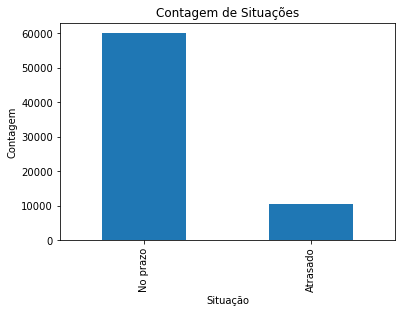

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que 'variaveis_interesse' é o seu DataFrame
# e 'situacao' é a coluna de interesse
variaveis_interesse['situacao'].value_counts().plot(kind='bar')

# Adicionando rótulos e título
plt.xlabel('Situação')
plt.ylabel('Contagem')
plt.title('Contagem de Situações')

# Exibindo o gráfico
plt.show()


C:\Users\rodri\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<Figure size 720x432 with 0 Axes>

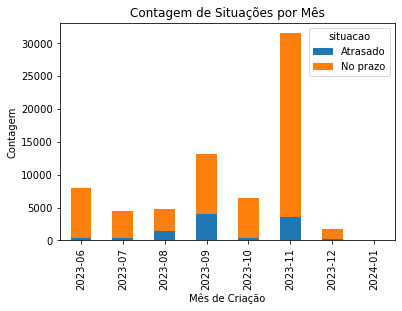

In [13]:
variaveis_interesse['mes'] = variaveis_interesse['data_criacao'].dt.to_period('M')

# Criando um gráfico de barras
plt.figure(figsize=(10, 6))
variaveis_interesse.groupby(['mes', 'situacao']).size().unstack().plot(kind='bar', stacked=True)

# Adicionando rótulos e título
plt.xlabel('Mês de Criação')
plt.ylabel('Contagem')
plt.title('Contagem de Situações por Mês')

# Exibindo o gráfico
plt.show()

C:\Users\rodri\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<Figure size 720x432 with 0 Axes>

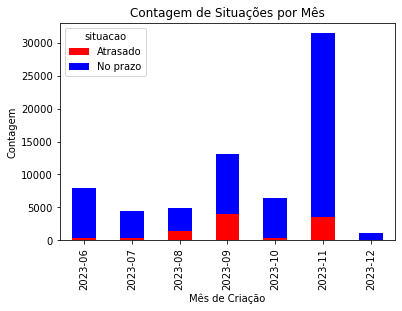

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace this with your actual data)

variaveis_interesse['mes'] = variaveis_interesse['data_criacao'].dt.to_period('M')

# Define colors for each 'situacao'
colors = {'No prazo': 'red',
          'Atrasado': 'blue'}

# Create a bar chart with specified colors
plt.figure(figsize=(10, 6))
variaveis_interesse.groupby(['mes', 'situacao']).size().unstack().plot(kind='bar', stacked=True, color=[colors.get(c, 'grey') for c in variaveis_interesse['situacao'].unique()])

# Adding labels and title
plt.xlabel('Mês de Criação')
plt.ylabel('Contagem')
plt.title('Contagem de Situações por Mês')

# Display the chart
plt.show()


In [14]:
contagem_por_mes_situacao = variaveis_interesse.groupby(['mes', 'situacao']).size().unstack()
contagem_por_mes_situacao['Porcentagem_Atrasado'] = (contagem_por_mes_situacao['Atrasado'] / contagem_por_mes_situacao.sum(axis=1)) * 100

In [15]:
contagem_por_mes_situacao

situacao,Atrasado,No prazo,Porcentagem_Atrasado
mes,,,
2023-06,437,7530,5.485126
2023-07,365,4082,8.207781
2023-08,1481,3367,30.548680
2023-09,3969,9194,30.152701
2023-10,336,6142,5.186786
2023-11,3606,27908,11.442533
2023-12,142,1629,8.018069
2024-01,3,136,2.158273


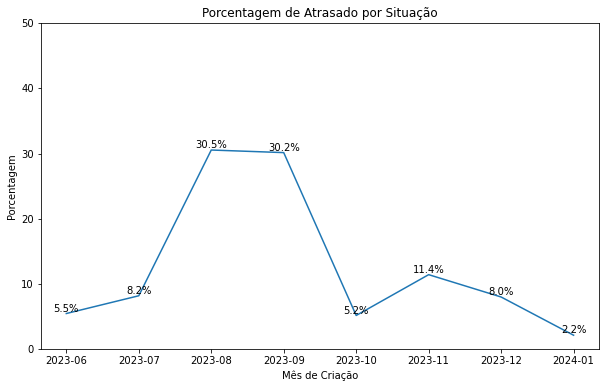

In [19]:
contagem_por_mes_situacao.index = contagem_por_mes_situacao.index.astype(str)

plt.figure(figsize=(10, 6))
ax = contagem_por_mes_situacao['Porcentagem_Atrasado'].plot(kind='line')
ax.set_ylim(0, 50)
plt.xlabel('Mês de Criação')
plt.ylabel('Porcentagem')
plt.title('Porcentagem de Atrasado por Situação')

for i, y in enumerate(contagem_por_mes_situacao['Porcentagem_Atrasado']):
    ax.text(i, y, f'{y:.1f}%', ha='center', va='bottom')
    
# Exibindo o gráfico
plt.show()

In [20]:
variaveis_interesse['situacao'].value_counts()

No prazo    59988
Atrasado    10339
Name: situacao, dtype: int64

In [21]:
porcentagem = round(10214 / (59354 + 10214),3)*100
print(f"Proporção de pedidos entregue atrasados {porcentagem} %")


Proporção de pedidos entregue atrasados 14.7 %


### Por transportadora

In [22]:
# Criando um gráfico de barras
transportadora_situacao = variaveis_interesse.groupby(['transportadora', 'situacao']).size().unstack()
transportadora_situacao['% entrega transp'] = round(transportadora_situacao['Atrasado'] / transportadora_situacao.sum(axis=1) * 100,2)
transportadora_situacao['% atraso totais'] =  round(transportadora_situacao['Atrasado'] / transportadora_situacao['Atrasado'].sum() *100,2)
transportadora_situacao


situacao,Atrasado,No prazo,% entrega transp,% atraso totais
transportadora,,,,
Braspress,50,31,61.73,0.48
Correios,46,209,18.04,0.44
Loggi,8737,42142,17.17,84.51
Total,1506,17606,7.88,14.57


## Análise por Estado

In [23]:
mapa = variaveis_interesse.groupby(['uf', 'situacao']).size().unstack()
mapa['% atraso totais'] =  round(mapa['Atrasado'] / mapa['Atrasado'].sum() *100,2)
mapa

situacao,Atrasado,No prazo,% atraso totais
uf,,,
AC,2.0,62.0,0.02
AL,23.0,343.0,0.22
AM,41.0,111.0,0.40
AP,2.0,15.0,0.02
BA,347.0,2939.0,3.36
CE,53.0,643.0,0.51
DF,342.0,2199.0,3.31
ES,183.0,1351.0,1.77
GO,145.0,1422.0,1.40


In [24]:
mapa = variaveis_interesse.groupby(['region', 'situacao']).size().unstack()
mapa['% atraso totais'] =  round(mapa['Atrasado'] / mapa['Atrasado'].sum() *100,2)
mapa

KeyError: 'region'

## Capital Interior

In [25]:
mapa = variaveis_interesse.groupby(['praca', 'situacao']).size().unstack()
mapa['% atraso totais'] =  round(mapa['Atrasado'] / mapa['Atrasado'].sum() *100,2)
mapa

situacao,Atrasado,No prazo,% atraso totais
praca,,,
Capital,7864,39752,76.06
Interior,2475,20236,23.94


### Transform a data retirando o UTC e hora

In [410]:
colunas_ajustar_data = ['data_entrega','data_criacao','previsao_entrega_transp',
                        'previsao_entrega_cliente','data_despacho']

for column in colunas_ajustar_data:
    base_modelo[column] = base_modelo[column].dt.date

In [12]:
base_modelo['tempo_dias_despacho'] = (base_modelo['data_despacho'] - base_modelo['data_criacao']).dt.days.astype(int)

C:\Users\rodri\AppData\Local\Temp\ipykernel_15256\3699523633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_modelo['tempo_dias_despacho'] = (base_modelo['data_despacho'] - base_modelo['data_criacao']).dt.days.astype(int)


In [55]:
dummy_df = pd.get_dummies(variaveis_interesse['transportadora'], prefix='transportadora')
variaveis_interesse = pd.concat([variaveis_interesse, dummy_df], axis=1)
variaveis_interesse.head()

,uf,transportadora,data_criacao,data_despacho,previsao_entrega_cliente,data_entrega,previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,...,quantidade_de_ocorrencias,situacao,mes,chave_acesso_NFe,criado_shopify,tempo_total_despacho,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total
0,AP,Loggi,2023-09-26 11:56:40.905000+00:00,2023-09-26 17:48:27+00:00,2023-10-15 23:58:59+00:00,2023-10-13 13:15:59+00:00,2023-10-13 23:59:59+00:00,Entregue,12.0,1,...,0.0,0,2023-09,32230927403527000385550010003578101810720732,2023-09-26 00:00:00+00:00,0,0,0,1,0
1,RO,Loggi,2023-09-30 10:16:37.745000+00:00,2023-10-02 18:12:46+00:00,2023-10-30 23:58:59+00:00,2023-10-16 16:51:59+00:00,2023-10-30 23:59:59+00:00,Entregue,19.0,0,...,0.0,0,2023-09,32230927403527000385550010003602701198636133,2023-09-30 00:00:00+00:00,2,0,0,1,0
2,MT,Loggi,2023-10-03 20:00:23.621000+00:00,2023-10-04 17:34:16+00:00,2023-10-25 23:58:59+00:00,2023-10-14 15:36:59+00:00,2023-10-25 23:59:59+00:00,Entregue,14.0,0,...,0.0,0,2023-10,32231027403527000385550010003628761554909498,2023-10-03 00:00:00+00:00,1,0,0,1,0
3,RO,Loggi,2023-10-04 07:49:10.653000+00:00,2023-10-04 17:34:16+00:00,2023-10-25 23:58:59+00:00,2023-10-25 10:14:59+00:00,2023-10-24 23:59:59+00:00,Entregue,13.0,0,...,0.0,0,2023-10,32231027403527000385550010003630721997739887,2023-10-04 00:00:00+00:00,0,0,0,1,0
4,RO,Loggi,2023-10-03 17:35:22.034000+00:00,2023-10-04 17:34:16+00:00,2023-10-24 23:58:59+00:00,2023-10-25 10:37:59+00:00,2023-10-24 23:59:59+00:00,Entregue,13.0,0,...,0.0,1,2023-10,32231027403527000385550010003627351403916136,2023-10-03 00:00:00+00:00,1,0,0,1,0


In [57]:
variaveis_interesse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70327 entries, 0 to 70326
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   uf                               70327 non-null  object             
 1   transportadora                   70327 non-null  object             
 2   data_criacao                     70327 non-null  datetime64[ns, UTC]
 3   data_despacho                    70327 non-null  datetime64[ns, UTC]
 4   previsao_entrega_cliente         70327 non-null  datetime64[ns, UTC]
 5   data_entrega                     70327 non-null  datetime64[ns, UTC]
 6   previsao_entrega_transp          70327 non-null  datetime64[ns, UTC]
 7   status_transportador             70327 non-null  object             
 8   prazo_transportadora_dias_uteis  70327 non-null  float64            
 9   praca                            70327 non-null  int64              
 10

## Transform states in regions

In [213]:
state_to_region = {
    'AC': 'Norte',
    'AL': 'Nordeste',
    'AP': 'Norte',
    'AM': 'Norte',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'DF': 'Centro-Oeste',
    'ES': 'Sudeste',
    'GO': 'Centro-Oeste',
    'MA': 'Nordeste',
    'MT': 'Centro-Oeste',
    'MS': 'Centro-Oeste',
    'MG': 'Sudeste',
    'PA': 'Norte',
    'PB': 'Nordeste',
    'PR': 'Sul',
    'PE': 'Nordeste',
    'PI': 'Nordeste',
    'RJ': 'Sudeste',
    'RN': 'Nordeste',
    'RS': 'Sul',
    'RO': 'Norte',
    'RR': 'Norte',
    'SC': 'Sul',
    'SP': 'Sudeste',
    'SE': 'Nordeste',
    'TO': 'Norte',
}
variaveis_interesse['region'] = variaveis_interesse['uf'].map(state_to_region)

In [16]:
dummy_df = pd.get_dummies(base_modelo['region'], prefix='regiao',drop_first=True)
base_modelo = pd.concat([base_modelo, dummy_df], axis=1)
base_modelo.head()

,uf,transportadora,data_despacho,status_transportador,data_do_ultimo_status,data_entrega,atualizado_em,previsao_entrega_cliente,situacao,performance,previsao_entrega_transp,previsao_entrega_transp_original,situacao_transp,performance_transp,data_criacao,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,tempo_dias_despacho,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total,region,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul
5235,MG,Total,2023-10-02,Entregue,2023-10-09,2023-10-09,2023-10-09,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-02,6.0,Interior,32231027403527000385550010003615231547080454,1.0,0,0,0,0,1,Sudeste,0,0,1,0
5236,SC,Loggi,2023-10-04,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,4.0,Interior,32231027403527000385550010003636441539962073,1.0,0,0,0,1,0,Sul,0,0,0,1
5237,SP,Loggi,2023-10-05,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,3.0,Capital,32231027403527000385550010003640741291237886,2.0,1,0,0,1,0,Sudeste,0,0,1,0
5238,PR,Loggi,2023-10-05,Entregue,2023-10-11,2023-10-11,2023-10-11,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003641311786182782,2.0,1,0,0,1,0,Sul,0,0,0,1
5239,SC,Loggi,2023-10-05,Entregue,2023-10-13,2023-10-13,2023-10-13,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003642241313504295,2.0,1,0,0,1,0,Sul,0,0,0,1


## Tempo de faturamento

In [26]:
notas = tuple(variaveis_interesse['chave_da_nota'])

In [27]:
df_notas = get_date_order(notas)

In [29]:
df_notas.head()

,chave_acesso_NFe,criado_shopify
0,32230627403527000385550010002895111923492112,2023-06-05
1,32230627403527000385550010002895251502594283,2023-06-05
2,32230627403527000385550010002895281999504143,2023-06-05
3,32230627403527000385550010002895321624548680,2023-06-05
4,32230627403527000385550010002895361048196820,2023-06-05


In [32]:
df_notas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69322 entries, 0 to 69321
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   chave_acesso_NFe  69322 non-null  object        
 1   criado_shopify    69322 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.1+ MB


In [38]:
df_notas['criado_shopify'] = pd.to_datetime(df_notas['criado_shopify'])

In [33]:
variaveis_interesse = variaveis_interesse.merge(
    df_notas, 
    left_on = 'chave_da_nota', right_on = 'chave_acesso_NFe', 
    how = 'left'
)

In [34]:
variaveis_interesse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70327 entries, 0 to 70326
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   uf                               70327 non-null  object             
 1   transportadora                   70327 non-null  object             
 2   data_criacao                     70327 non-null  datetime64[ns, UTC]
 3   data_despacho                    70327 non-null  datetime64[ns, UTC]
 4   previsao_entrega_cliente         70327 non-null  datetime64[ns, UTC]
 5   data_entrega                     70327 non-null  datetime64[ns, UTC]
 6   previsao_entrega_transp          70327 non-null  datetime64[ns, UTC]
 7   status_transportador             70327 non-null  object             
 8   prazo_transportadora_dias_uteis  70327 non-null  float64            
 9   praca                            70327 non-null  object             
 10

In [35]:
variaveis_interesse['criado_shopify'].isnull().sum()

1005

In [36]:
variaveis_interesse['criado_shopify'] = variaveis_interesse['criado_shopify'].fillna(variaveis_interesse['data_criacao'])

In [44]:
variaveis_interesse['criado_shopify']

0       2023-09-26 00:00:00+00:00
1       2023-09-30 00:00:00+00:00
2       2023-10-03 00:00:00+00:00
3       2023-10-04 00:00:00+00:00
4       2023-10-03 00:00:00+00:00
                   ...           
70322   2023-06-07 00:00:00+00:00
70323   2023-06-07 00:00:00+00:00
70324   2023-06-07 00:00:00+00:00
70325   2023-06-07 00:00:00+00:00
70326   2023-06-07 00:00:00+00:00
Name: criado_shopify, Length: 70327, dtype: datetime64[ns, UTC]

# Tempo integração até despacho

In [43]:
variaveis_interesse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70327 entries, 0 to 70326
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   uf                               70327 non-null  object             
 1   transportadora                   70327 non-null  object             
 2   data_criacao                     70327 non-null  datetime64[ns, UTC]
 3   data_despacho                    70327 non-null  datetime64[ns, UTC]
 4   previsao_entrega_cliente         70327 non-null  datetime64[ns, UTC]
 5   data_entrega                     70327 non-null  datetime64[ns, UTC]
 6   previsao_entrega_transp          70327 non-null  datetime64[ns, UTC]
 7   status_transportador             70327 non-null  object             
 8   prazo_transportadora_dias_uteis  70327 non-null  float64            
 9   praca                            70327 non-null  object             
 10

In [104]:
variaveis_interesse.head()

,uf,transportadora,data_criacao,data_despacho,previsao_entrega_cliente,data_entrega,previsao_entrega_transp,status_transportador,prazo_transportadora_dias_uteis,praca,...,quantidade_de_ocorrencias,situacao,mes,chave_acesso_NFe,criado_shopify,tempo_total_despacho,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total
0,AP,Loggi,2023-09-26 11:56:40.905000+00:00,2023-09-26 17:48:27+00:00,2023-10-15 23:58:59+00:00,2023-10-13 13:15:59+00:00,2023-10-13 23:59:59+00:00,Entregue,12.0,1,...,0.0,0,2023-09,32230927403527000385550010003578101810720732,2023-09-26 00:00:00+00:00,0,0,0,1,0
1,RO,Loggi,2023-09-30 10:16:37.745000+00:00,2023-10-02 18:12:46+00:00,2023-10-30 23:58:59+00:00,2023-10-16 16:51:59+00:00,2023-10-30 23:59:59+00:00,Entregue,19.0,0,...,0.0,0,2023-09,32230927403527000385550010003602701198636133,2023-09-30 00:00:00+00:00,2,0,0,1,0
2,MT,Loggi,2023-10-03 20:00:23.621000+00:00,2023-10-04 17:34:16+00:00,2023-10-25 23:58:59+00:00,2023-10-14 15:36:59+00:00,2023-10-25 23:59:59+00:00,Entregue,14.0,0,...,0.0,0,2023-10,32231027403527000385550010003628761554909498,2023-10-03 00:00:00+00:00,1,0,0,1,0
3,RO,Loggi,2023-10-04 07:49:10.653000+00:00,2023-10-04 17:34:16+00:00,2023-10-25 23:58:59+00:00,2023-10-25 10:14:59+00:00,2023-10-24 23:59:59+00:00,Entregue,13.0,0,...,0.0,0,2023-10,32231027403527000385550010003630721997739887,2023-10-04 00:00:00+00:00,0,0,0,1,0
4,RO,Loggi,2023-10-03 17:35:22.034000+00:00,2023-10-04 17:34:16+00:00,2023-10-24 23:58:59+00:00,2023-10-25 10:37:59+00:00,2023-10-24 23:59:59+00:00,Entregue,13.0,0,...,0.0,1,2023-10,32231027403527000385550010003627351403916136,2023-10-03 00:00:00+00:00,1,0,0,1,0


In [42]:
variaveis_interesse['criado_shopify'] = pd.to_datetime(variaveis_interesse['criado_shopify'],utc = True)

In [45]:
variaveis_interesse['tempo_total_despacho'] = (variaveis_interesse['data_despacho'] - variaveis_interesse['criado_shopify']).dt.days.astype(int)

In [47]:
variaveis_interesse['tempo_total_despacho'].describe()

count    70327.000000
mean         2.380778
std          2.011309
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         38.000000
Name: tempo_total_despacho, dtype: float64

<AxesSubplot:>

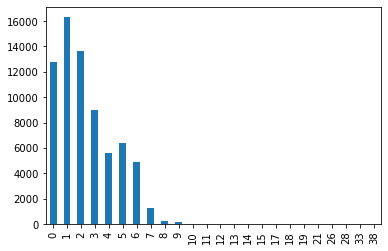

In [49]:
variaveis_interesse['tempo_total_despacho'].value_counts().sort_index().plot(kind='bar')


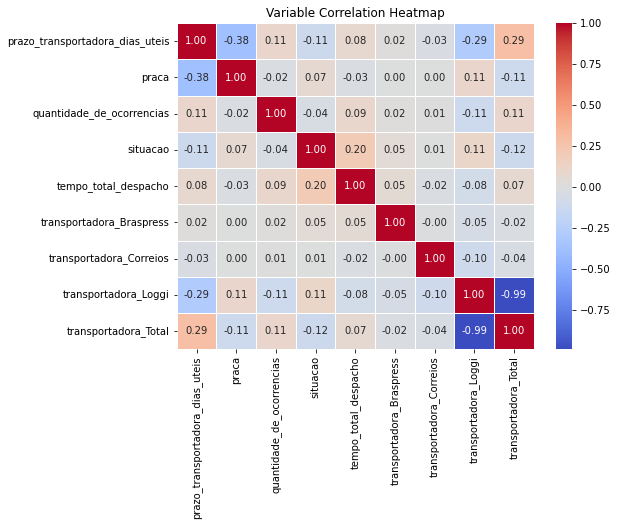

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace this with your actual data)
# Assuming df is your DataFrame with numerical columns

# Calculate the correlation matrix
correlation_matrix = variaveis_interesse.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Adding title
plt.title('Variable Correlation Heatmap')

# Display the chart
plt.show()


## Mudar as variáveis para binárias -> fora do prazo e praça

In [50]:
mapeamento = {
    "No prazo": 0, "Atrasado": 1,
    "Capital":1, "Interior":0,}


In [53]:
variaveis_interesse[['situacao','praca']] = variaveis_interesse[['situacao','praca']].replace(mapeamento)

### Definindo Variáveis X e Y

In [87]:
y = variaveis_interesse['situacao']
X = variaveis_interesse[['prazo_transportadora_dias_uteis','praca','tempo_total_despacho','quantidade_de_ocorrencias',
                 'transportadora_Braspress','transportadora_Correios','transportadora_Loggi','transportadora_Total']]

In [88]:
y.value_counts()

0    59988
1    10339
Name: situacao, dtype: int64

In [109]:
import statsmodels.api as sm

# Function for stepwise forward selection
def forward_selected(data, response):
    remaining = set(data.columns)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response, ' + '.join(selected + [candidate]))
            model = sm.OLS.from_formula(formula, data)
            result = model.fit()
            score = result.rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score > best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {}".format(response, ' + '.join(selected))
    model = sm.OLS.from_formula(formula, data)
    result = model.fit()
    return result

# Combine X and y into a single DataFrame
data = pd.concat([X, y], axis=1)

# Perform forward stepwise selection
result = forward_selected(data, 'situacao')

# Display the selected features and summary
print(result.model.formula)
print(result.summary())

KeyboardInterrupt: 

### Separando em base e treino

In [101]:
#Regressão Logística

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

logistic_regression = LogisticRegression(class_weight='balanced')
logistic_regression.fit(X_train,y_train)
ypred = logistic_regression.predict(X_test)

In [102]:
acuracia = metrics.accuracy_score(y_test,ypred)
log_loss = metrics.log_loss(y_test,ypred)
roc_auc = metrics.roc_auc_score(y_test,ypred)
classification = metrics.classification_report(y_test, ypred)
cm = metrics.confusion_matrix(y_test, ypred)


print(f"variaveis independentes: {X.columns}\n")
print(f"Acurácia: {acuracia}\n")
print(f"Log loss: {log_loss}\n")
print(f"Curva Roc: {roc_auc}\n")
print(f"Classification Report")
print(classification)
print(f"matriz de confusão:")
print(cm)


variaveis independentes: Index(['prazo_transportadora_dias_uteis', 'praca', 'tempo_total_despacho',
       'quantidade_de_ocorrencias', 'transportadora_Braspress',
       'transportadora_Correios', 'transportadora_Loggi',
       'transportadora_Total'],
      dtype='object')

Acurácia: 0.6656239335684222

Log loss: 11.549163942955094

Curva Roc: 0.6520955387037475

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.67      0.77     14970
           1       0.25      0.63      0.36      2612

    accuracy                           0.67     17582
   macro avg       0.58      0.65      0.57     17582
weighted avg       0.81      0.67      0.71     17582

matriz de confusão:
[[10050  4920]
 [  959  1653]]


### Ploting  Confusion Matrix

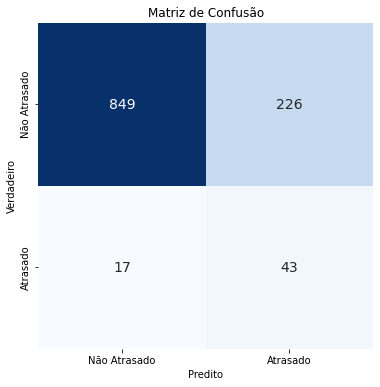

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 14}, xticklabels=["Não Atrasado", "Atrasado"],
            yticklabels=["Não Atrasado", "Atrasado"])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### Backlog

In [99]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

# Example with class_weight parameter
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train,y_train)
ypred = model.predict(X_test)

# ANOTAÇÕES

In [317]:
## Calcular manualmente a performance